Step 1:

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('SN_y_tot_V2.0.csv', delimiter=';', header=None, names=['time', 'sunspots', 'std', 'obs', 'def'])

# Function to convert fractional year to datetime
def fractional_year_to_date(year):
    """
    Converts fractional years (e.g., 1749.042) into a datetime object.
    Args:
        year (float): The year in fractional format.
    Returns:
        datetime: A datetime object corresponding to the fractional year.
    """
    year_int = int(year)  # Extract the integer part of the year
    fraction = year - year_int  # Extract the fractional part
    month = int(fraction * 12) + 1  # Convert fraction to a month (1-based index)
    return datetime(year_int, month, 1)
    


In [3]:
# Convert fractional year to datetime
df['ds'] = df['time'].apply(fractional_year_to_date)
df['y'] = df['sunspots']

# Keep only necessary columns for Prophet
df = df[['ds', 'y']]

# Filter data from 1800 onwards
df = df[df['ds'] >= datetime(1800, 1, 1)]

# Check the processed dataframe
print("Filtered Data (from 1800):")
print(df.head())

# Define forecasting parameters
future_periods = [1, 10, 20]  # Years into the future

# Initialize a dictionary to store results for each model
evaluation_results = []

Filtered Data (from 1800):
            ds     y
100 1800-07-01  24.2
101 1801-07-01  56.7
102 1802-07-01  75.0
103 1803-07-01  71.8
104 1804-07-01  79.2


Step 2:


Forecasting for 1 year(s) into the future...


C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



Forecasted Values:
            ds       yhat  yhat_lower  yhat_upper
222 2021-12-31  44.053075   -37.05912  120.823128


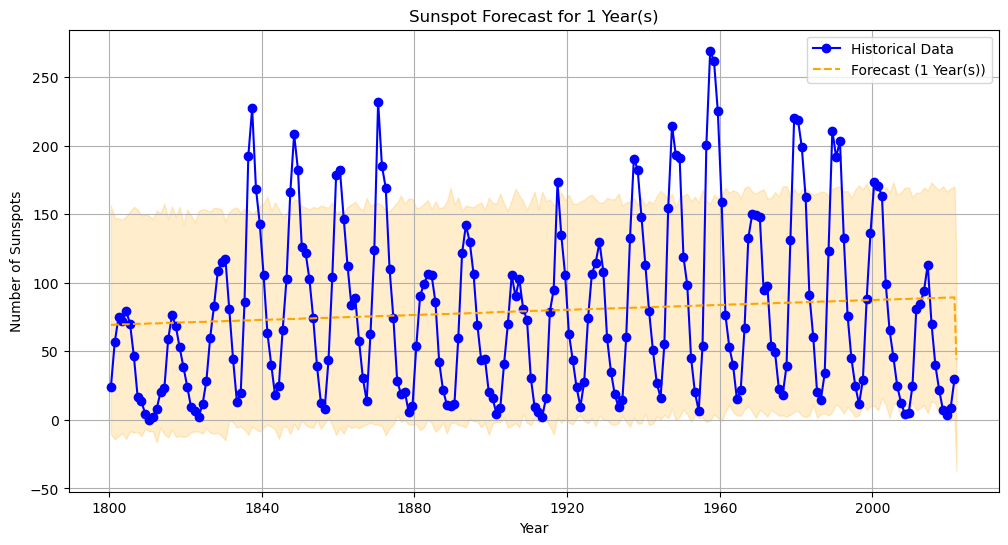


Forecasting for 10 year(s) into the future...


C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



Forecasted Values:
            ds       yhat  yhat_lower  yhat_upper
222 2021-12-31  44.053075  -35.875065  124.884134
223 2022-12-31  44.131354  -40.746105  128.618218
224 2023-12-31  44.211731  -33.549624  125.323160
225 2024-12-31  44.335188  -37.351429  130.196292
226 2025-12-31  44.411376  -33.034921  123.995995
227 2026-12-31  44.489656  -31.591714  121.804369
228 2027-12-31  44.570032  -33.598563  126.710319
229 2028-12-31  44.693489  -34.591348  130.806737
230 2029-12-31  44.769678  -32.831593  124.103116
231 2030-12-31  44.847957  -34.985475  127.653843


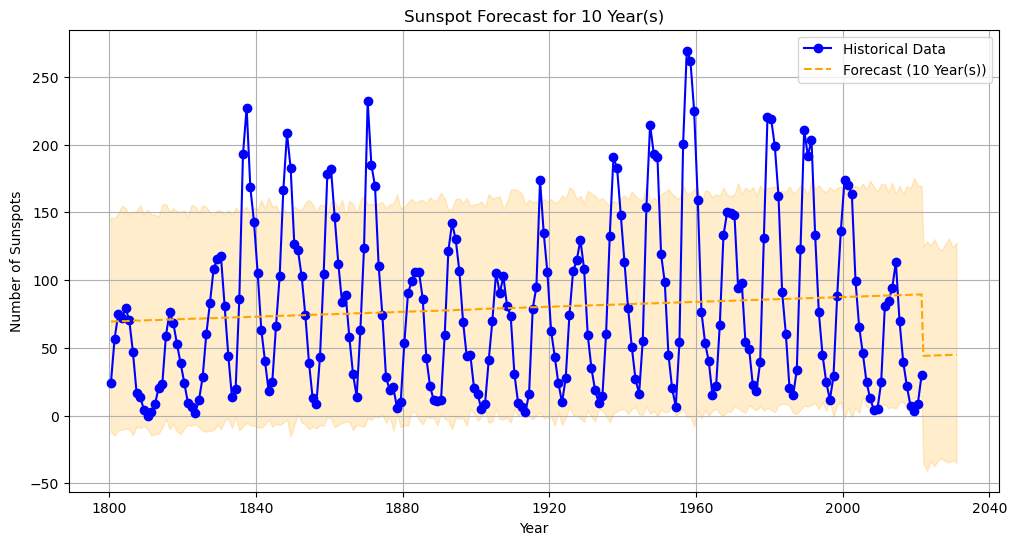


Forecasting for 20 year(s) into the future...


C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



Forecasted Values:
            ds       yhat  yhat_lower  yhat_upper
222 2021-12-31  44.053075  -36.736525  121.465795
223 2022-12-31  44.131354  -41.387407  121.880924
224 2023-12-31  44.211731  -35.592677  122.920698
225 2024-12-31  44.335188  -34.548401  128.941350
226 2025-12-31  44.411376  -41.805598  121.693840
227 2026-12-31  44.489656  -33.105285  127.114710
228 2027-12-31  44.570032  -32.545407  122.812327
229 2028-12-31  44.693489  -37.929626  123.446722
230 2029-12-31  44.769678  -28.489710  121.953633
231 2030-12-31  44.847957  -38.277339  125.799764
232 2031-12-31  44.928333  -37.958094  126.901039
233 2032-12-31  45.051791  -34.017541  127.433233
234 2033-12-31  45.127979  -35.154841  123.464699
235 2034-12-31  45.206258  -36.559746  127.620850
236 2035-12-31  45.286635  -30.423628  125.271135
237 2036-12-31  45.410092  -35.885061  129.029716
238 2037-12-31  45.486280  -29.068696  130.656998
239 2038-12-31  45.564560  -32.911219  120.267965
240 2039-12-31  45.644936  -37

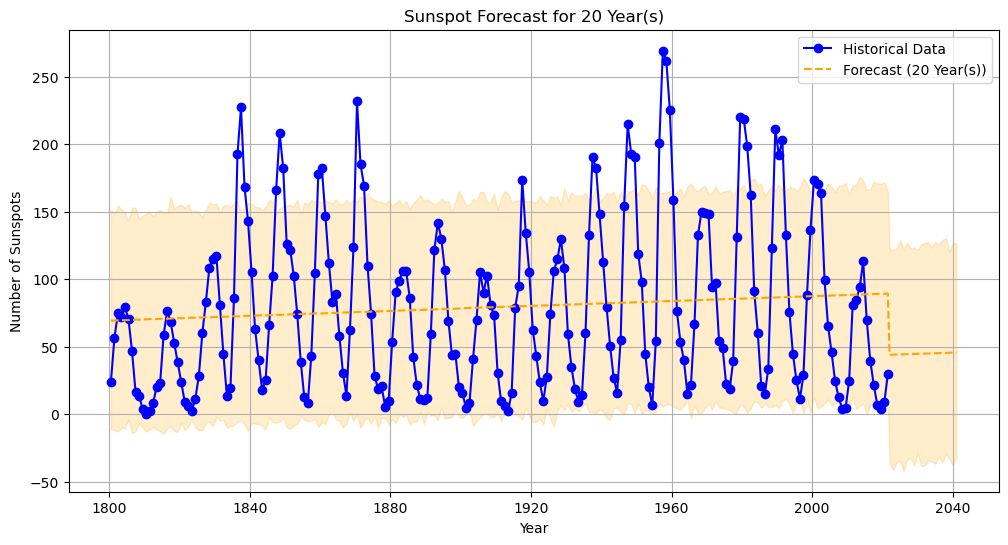

In [39]:
# Train and forecast with different settings
for period in future_periods:
    print(f"\nForecasting for {period} year(s) into the future...")

    # Initialize the Prophet model
    model = Prophet(growth='linear',  # Use 'linear' growth as default (can also test 'logistic' or 'flat')
                    n_changepoints=25,  # Number of changepoints (tuneable)
                    changepoint_prior_scale=0.05)  # Regularization strength for the changepoint flexibility
    
    # Add manual seasonality (try different values for period and fourier_order)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=5)  # Add yearly seasonality
    
    # Fit the model to the filtered data
    model.fit(df)
    
    # Make predictions for the specified number of years into the future
    future = model.make_future_dataframe(periods=period, freq='Y')  # Yearly frequency
    forecast = model.predict(future)

    # Extract the forecasted values for evaluation
    forecast_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(period)
    print("\nForecasted Values:")
    print(forecast_values)

    # Append forecast for later use
    results = {
        'period': period,
        'forecast': forecast_values,
        'forecast_full': forecast  # Include the full forecast for plotting and evaluation
    }

    # Plot the forecast as a line graph
    plt.figure(figsize=(12, 6))
    
    # Plot historical data
    plt.plot(df['ds'], df['y'], label='Historical Data', color='blue', marker='o')

    # Plot forecasted data
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Forecast ({period} Year(s))', color='orange', linestyle='--')

    # Plot uncertainty intervals
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)

    # Add labels and title
    plt.title(f"Sunspot Forecast for {period} Year(s)")
    plt.xlabel("Year")
    plt.ylabel("Number of Sunspots")
    plt.legend()
    plt.grid(True)
    plt.show()

Step 3: (a)

C:\Users\hp\AppData\Local\Temp\ipykernel_1784\402162117.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Use 'Y' for yearly frequency
10:57:18 - cmdstanpy - INFO - Chain [1] start processing
10:57:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


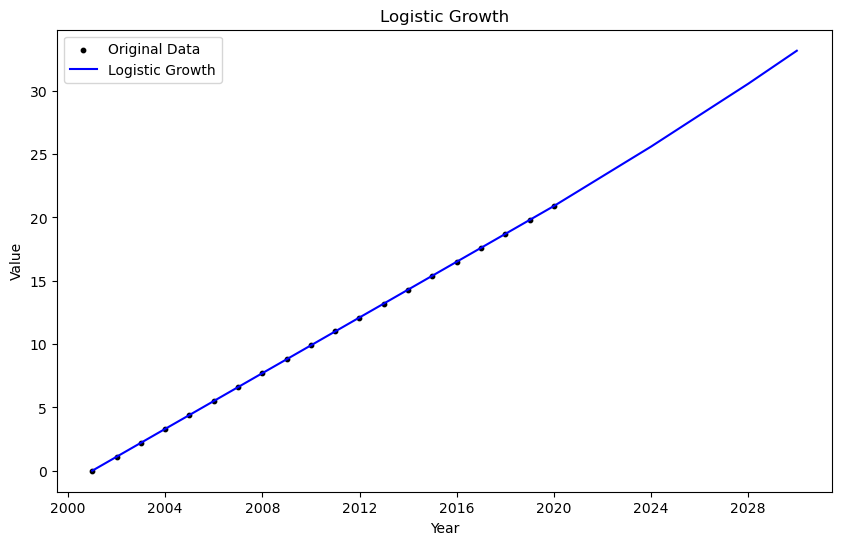

In [4]:
import logging

# Suppress cmdstanpy logs (optional)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Example data setup (replace with your dataset)
data = pd.DataFrame({
    'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Use 'Y' for yearly frequency
    'y': [i + (i * 0.1) for i in range(20)]  # Simulated linear growth
})

# Logistic Growth
data['cap'] = 150  # Example upper limit for logistic growth
model_logistic = Prophet(growth='logistic')
model_logistic.fit(data)

future_logistic = model_logistic.make_future_dataframe(periods=10, freq='Y')  # Use 'Y' for yearly
future_logistic['cap'] = 150
forecast_logistic = model_logistic.predict(future_logistic)

plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], data['y'], label='Original Data', color='black', s=10)
plt.plot(forecast_logistic['ds'], forecast_logistic['yhat'], label='Logistic Growth', color='blue')
plt.title("Logistic Growth")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()





10:57:49 - cmdstanpy - INFO - Chain [1] start processing
10:57:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


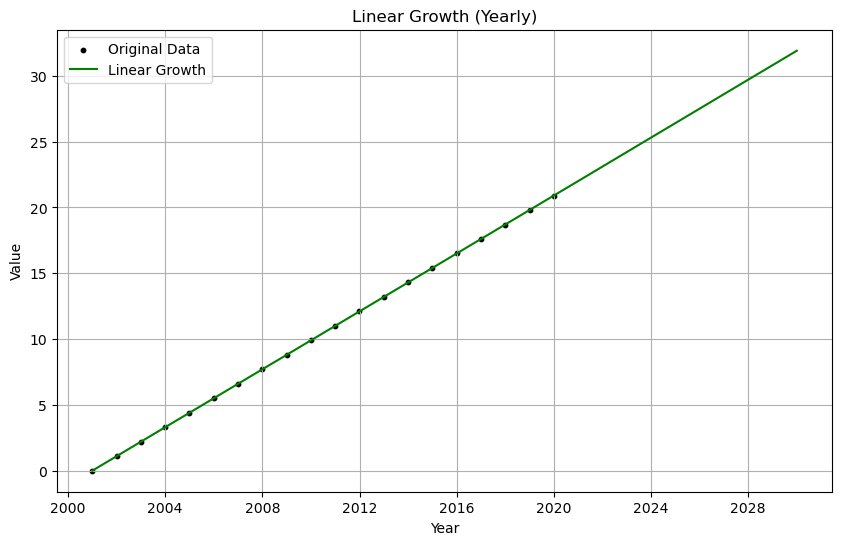

In [5]:
# Linear Growth
model_linear = Prophet()  # Default is linear
model_linear.fit(data)

future_linear = model_linear.make_future_dataframe(periods=10, freq='Y')  # Use 'Y' for yearly
forecast_linear = model_linear.predict(future_linear)

# Linear Growth Plot
plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], data['y'], label='Original Data', color='black', s=10)
plt.plot(forecast_linear['ds'], forecast_linear['yhat'], label='Linear Growth', color='green')
plt.title("Linear Growth (Yearly)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


10:58:13 - cmdstanpy - INFO - Chain [1] start processing
10:58:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


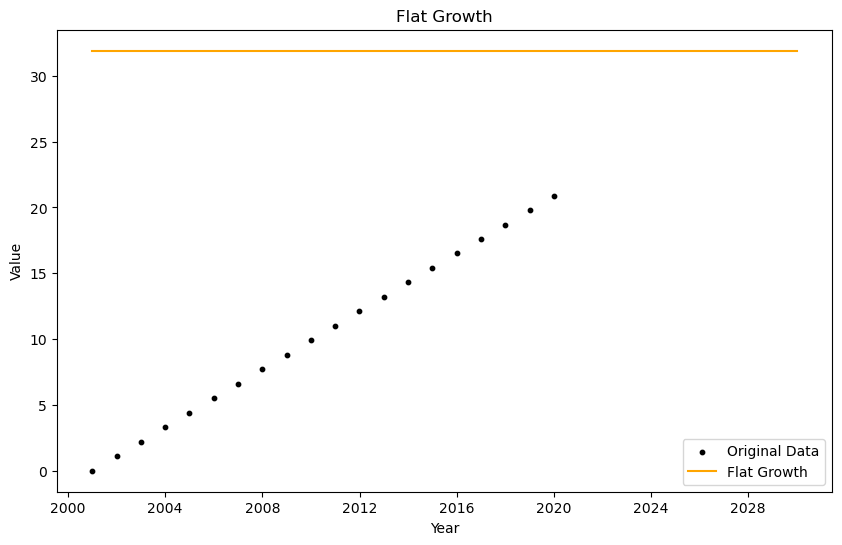

In [6]:
# Flat Growth (constant yhat beyond known data)
model_flat = Prophet()
model_flat.fit(data)

future_flat = model_flat.make_future_dataframe(periods=10, freq='Y')  # Use 'Y' for yearly
forecast_flat = model_flat.predict(future_flat)
forecast_flat['yhat'] = forecast_flat['yhat'].iloc[-1]  # Keep constant

plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], data['y'], label='Original Data', color='black', s=10)
plt.plot(forecast_flat['ds'], forecast_flat['yhat'], label='Flat Growth', color='orange')
plt.title("Flat Growth")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()


(b)

C:\Users\hp\AppData\Local\Temp\ipykernel_1784\3338215097.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Yearly frequency
11:00:58 - cmdstanpy - INFO - Chain [1] start processing
11:00:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


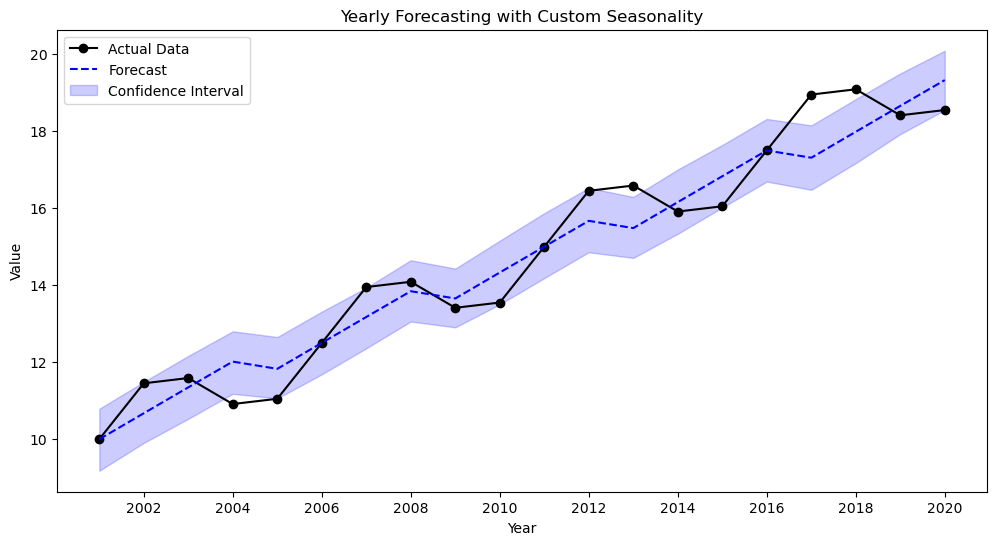

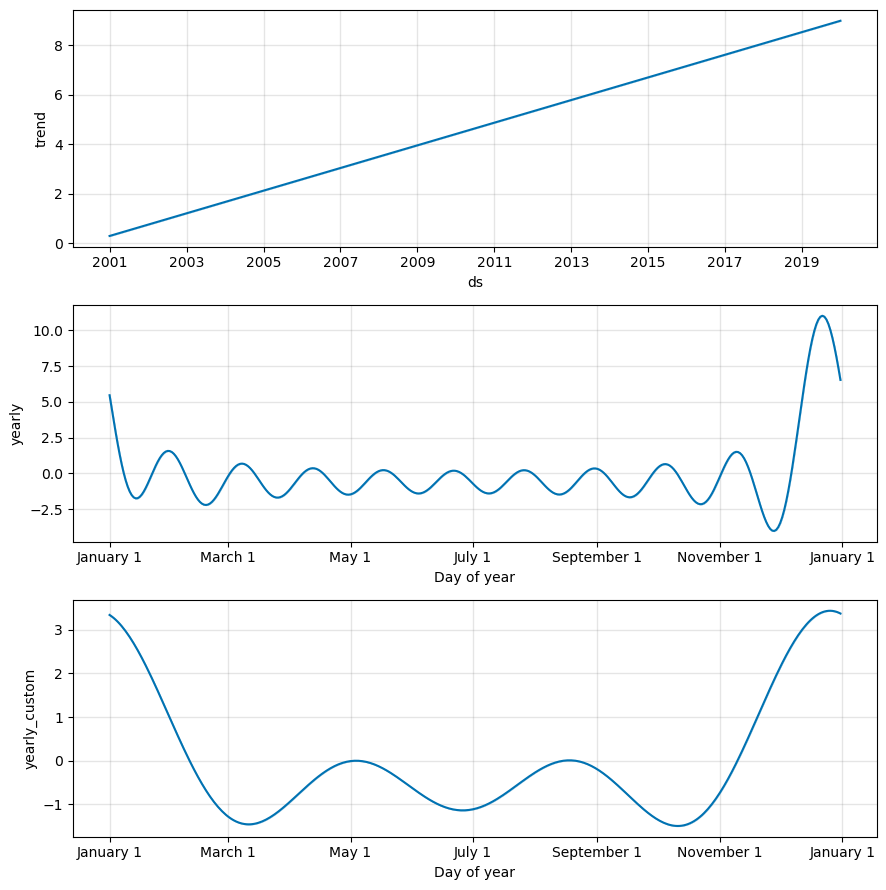

Evaluation Metrics for Yearly Forecasting with Custom Seasonality:
MAE: 0.94
MAPE: 4.99%
R²: -13.79


In [9]:
# Simulated yearly data (starting from 2000)
yearly_data = pd.DataFrame({
    'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Yearly frequency
    'y': [10 + 0.5 * i + np.sin(2 * np.pi * i / 5) for i in range(20)]  # Simulated yearly data
})

# Train/test split
train = yearly_data.iloc[:-4]
test = yearly_data.iloc[-4:]

# Train a Prophet model with custom seasonality
model = Prophet()

# Add manual seasonality
# Example 1: Yearly seasonality with period = 365.25 days (1 year) and Fourier order = 3
model.add_seasonality(name='yearly_custom', period=365.25, fourier_order=3)

# Fit the model
model.fit(train)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=4, freq='Y')  # Predict next 4 years
forecast = model.predict(future)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['ds'], yearly_data['y'], label='Actual Data', marker='o', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
plt.title("Yearly Forecasting with Custom Seasonality")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()

# Plot forecast components
model.plot_components(forecast)
plt.show()

# Evaluate the model
predicted = forecast.iloc[-4:]['yhat']
actual = test['y']

mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
r2 = r2_score(actual, predicted)

# Output evaluation metrics
print("Evaluation Metrics for Yearly Forecasting with Custom Seasonality:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²: {r2:.2f}")


(c)

C:\Users\hp\AppData\Local\Temp\ipykernel_1784\899841254.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Yearly frequency
11:07:10 - cmdstanpy - INFO - Chain [1] start processing
11:07:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


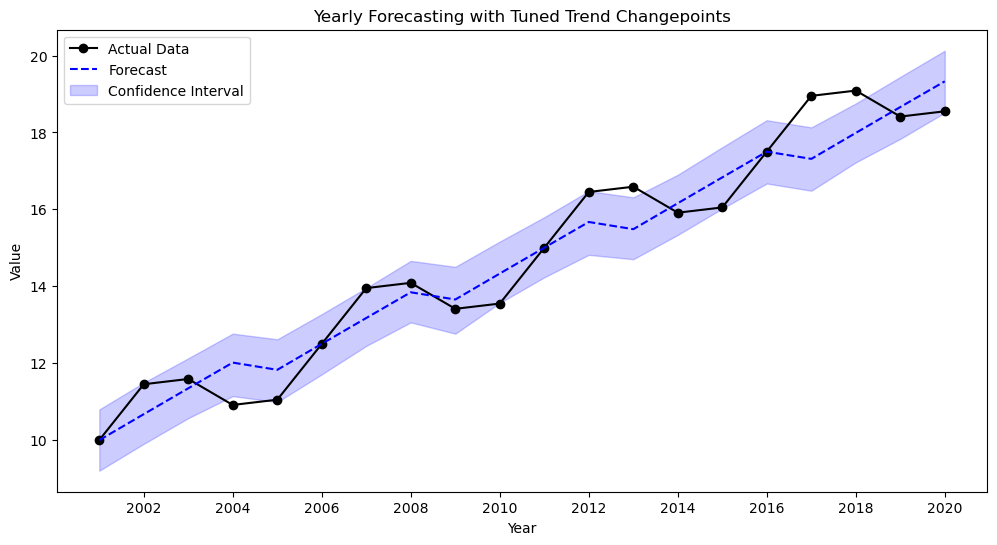

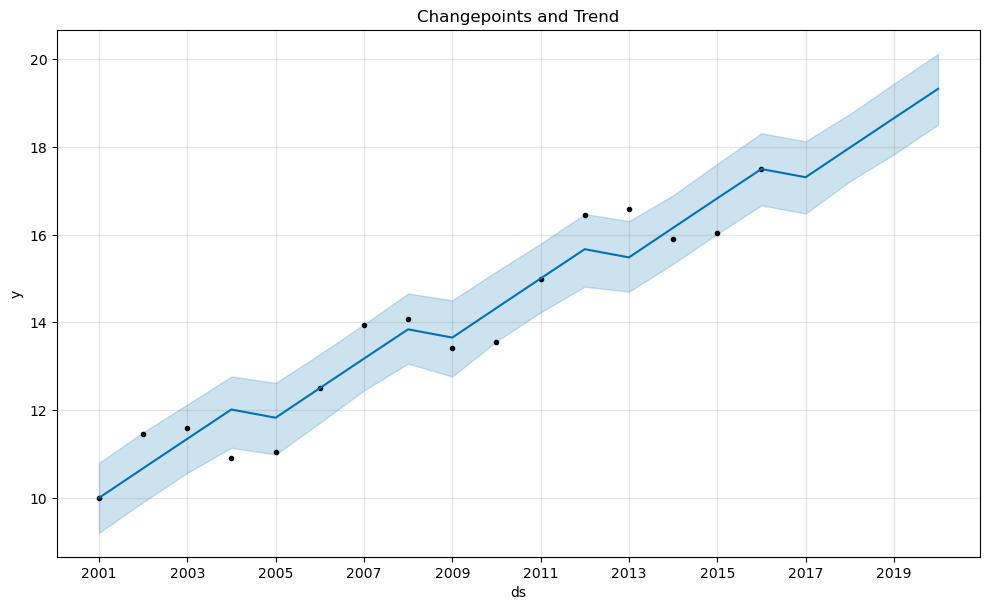

Evaluation Metrics for Yearly Forecasting with Tuned Trend Changepoints:
MAE: 0.94
MAPE: 4.99%
R²: -13.78


In [10]:
# Simulated yearly data (starting from 2000)
yearly_data = pd.DataFrame({
    'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Yearly frequency
    'y': [10 + 0.5 * i + np.sin(2 * np.pi * i / 5) for i in range(20)]  # Simulated yearly data
})

# Train/test split
train = yearly_data.iloc[:-4]
test = yearly_data.iloc[-4:]

# Initialize Prophet model with tuned changepoints
model = Prophet(
    n_changepoints=5,  # Number of potential trend changepoints
    changepoint_prior_scale=0.05  # Flexibility of the trend (lower values = less flexible)
)

# Fit the model
model.fit(train)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=4, freq='Y')  # Predict next 4 years
forecast = model.predict(future)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['ds'], yearly_data['y'], label='Actual Data', marker='o', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
plt.title("Yearly Forecasting with Tuned Trend Changepoints")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()

# Plot changepoints and trend
model.plot(forecast)
plt.title("Changepoints and Trend")
plt.show()

# Evaluate the model
predicted = forecast.iloc[-4:]['yhat']
actual = test['y']

mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
r2 = r2_score(actual, predicted)

# Output evaluation metrics
print("Evaluation Metrics for Yearly Forecasting with Tuned Trend Changepoints:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²: {r2:.2f}")


Step 4:

In [8]:
# Simulated yearly data (starting from 2000)
yearly_data = pd.DataFrame({
    'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Yearly frequency
    'y': [10 + 0.5 * i + np.sin(2 * np.pi * i / 10) for i in range(20)]  # Simulated yearly data
})

# Split into train/test sets (train for 16 years, test for the last 4 years)
train = yearly_data.iloc[:-4]
test = yearly_data.iloc[-4:]

# Train a Prophet model
model = Prophet()
model.fit(train)

# Make future predictions (forecasting for the next 4 years)
future = model.make_future_dataframe(periods=4, freq='Y')  # Yearly forecasting
forecast = model.predict(future)

# Extract predicted values for the test set
predicted = forecast.iloc[-4:]['yhat']
actual = test['y']

# Evaluate using MAE, MAPE, and R²
mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
r2 = r2_score(actual, predicted)

# Output the evaluation results
print(f"Model Evaluation for Yearly Forecasting:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²: {r2:.2f}")



C:\Users\hp\AppData\Local\Temp\ipykernel_1784\1135583846.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  'ds': pd.date_range(start='2000-01-01', periods=20, freq='Y'),  # Yearly frequency
10:59:29 - cmdstanpy - INFO - Chain [1] start processing
10:59:29 - cmdstanpy - INFO - Chain [1] done processing


Model Evaluation for Yearly Forecasting:
MAE: 0.97
MAPE: 5.43%
R²: -1.87


C:\Users\hp\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [7]:
# Example data setup
data = pd.DataFrame({
    'sigma_d': [0.5, 0.4, 0.6, 0.45],  # Daily standard deviations
    'N_d': [20, 25, 15, 18]  # Number of observations per day
})

# Calculate squared daily standard deviations
data['sigma_d_squared'] = data['sigma_d'] ** 2

# Calculate weighted sum of squared daily standard deviations
weighted_sum = np.sum(data['N_d'] * data['sigma_d_squared'])

# Sum the number of observations
total_observations = np.sum(data['N_d'])

# Calculate yearly standard deviation
sigma_m = np.sqrt(weighted_sum / total_observations)

print(f"Yearly standard deviation: {sigma_m}")


Yearly standard deviation: 0.48098456716006366
